In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Dataloader creation

In [8]:
# Define custom dataset class for FER2013
class TensorFromDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.data.iloc[idx, 1]
        pixels = [int(pixel) for pixel in img_name.split(' ')]
        image = torch.tensor(pixels, dtype=torch.float32).reshape(48, 48)

        label = int(self.data.iloc[idx, 0])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# # Define transformations for preprocessing
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Grayscale(num_output_channels=1),
#     transforms.Resize((64, 64)),  # Resize the images to match model input size
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])
# transform = None
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

df = pd.read_csv('fer2013/fer2013/fer2013.csv')
training = df[df['Usage'] == 'Training']
validation = df[df['Usage'] == 'PublicTest']
testing = df[df['Usage'] == 'PrivateTest']

# Load FER2013 dataset

train_set = TensorFromDataset(data = training, transform=transform)
valid_set = TensorFromDataset(data = validation, transform=transform)
test_set = TensorFromDataset(data = testing, transform=transform)


# Create data loaders
batch_size = 32
data_loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
data_loader_validation = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [9]:
def split_dataset(loader):
    # Create a DataLoader for the dataset
    # loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Initialize lists to store the features and labels
    features = []
    labels = []

    # Iterate through the DataLoader
    for imgs, lbls in loader:
        # Depending on your model, you might want to move your tensors to a device like CUDA
        imgs, lbls = imgs.cuda(), lbls.cuda()
        
        # Append the batch to the lists
        features.append(imgs)
        labels.append(lbls)

    # Concatenate all batches
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    

    return features, labels

In [10]:
# Now, you can use this function to split your test_set
X_test, Y_test = split_dataset(data_loader_test)

In [4]:


# for i, (inputs, labels) in enumerate(data_loader_train):
#     print(f"Batch {i}:")
#     print("Inputs:", inputs.shape)
#     print("Labels:",labels.shape)

In [11]:
# Model 1 definition

def Model1():
    model = nn.Sequential(
        # Convolutional layer 1
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Convolutional layer 2
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Convolutional layer 3
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        # Flatten the output for fully connected layers
        nn.Flatten(),

        # Fully connected layers
        nn.Linear(64 * 6 * 6, 128),  # Adjust the input size based on the output size of the previous layer
        nn.ReLU(),
        nn.Linear(128, 7)  # Adjust the output size based on the number of classes in your classification task
    )

    # Print the model architecture
    print(model)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    return model


In [12]:
model1 = Model1()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)


In [30]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet18 model
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Modify the input layer to accept 1 channel instead of 3
# ResNet's original first conv layer: nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_ft.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Assume the original weights are for RGB channels
original_weights = model_ft.conv1.weight.data

# Average the weights across the RGB channels
# This converts the [64, 3, 7, 7] weight matrix to [64, 1, 7, 7]
new_weights = original_weights.mean(dim=1, keepdim=True)

# Replace the weights in the modified conv1 layer
model_ft.conv1.weight.data = new_weights

# Number of features in the last layer
num_ftrs = model_ft.fc.in_features

# Replace the fully connected layer
model_ft.fc = nn.Linear(num_ftrs, 7)



In [27]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 7)

# model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\30698/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 36.2MB/s]


In [31]:
def train_model(model, training_data_loader, validation_data_loader, num_epochs, model_name):
    # Move model and data to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model1.parameters(), lr=0.001)

    # Train the model
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in training_data_loader:

            #this shoul be added only if running in GPU, otherwise comment
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(data_loader_train)}")

    # Example model class name extraction and save
    filename = f'{model_name}_weights.pth'
    torch.save(model.state_dict(), filename)

In [44]:
train_model(model1, data_loader_train, data_loader_validation, 20, 'model1')

Epoch [1/20], Loss: 1.657724063884973
Epoch [2/20], Loss: 1.4263919035682169
Epoch [3/20], Loss: 1.300288135862032
Epoch [4/20], Loss: 1.2122624912745172
Epoch [5/20], Loss: 1.140012681749722
Epoch [6/20], Loss: 1.069885853205067
Epoch [7/20], Loss: 1.0105740844805151
Epoch [8/20], Loss: 0.9442855734668489
Epoch [9/20], Loss: 0.8796566252519931
Epoch [10/20], Loss: 0.8185191930070487
Epoch [11/20], Loss: 0.7519765782329713
Epoch [12/20], Loss: 0.6934847162667256
Epoch [13/20], Loss: 0.6317770102109038
Epoch [14/20], Loss: 0.5733695519063414
Epoch [15/20], Loss: 0.5202068236629522
Epoch [16/20], Loss: 0.47183980314861695
Epoch [17/20], Loss: 0.42283534310044585
Epoch [18/20], Loss: 0.3789655471548338
Epoch [19/20], Loss: 0.3406681058003271
Epoch [20/20], Loss: 0.3085716105790141


In [32]:
train_model(model_ft, data_loader_train, data_loader_validation, 20, 'model_pretrained')

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Load and evaluate the model

In [13]:
model1 = Model1()
model_name = 'model1'
filename = f'{model_name}_weights.pth'
model1.load_state_dict(torch.load(filename))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2304, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=7, bias=True)
)


<All keys matched successfully>

In [6]:
# for i, (inputs, labels) in enumerate(data_loader_test):
#     print(f"Batch {i}:")
#     # print("Inputs:", inputs.shape)
#     print("Labels:",labels)

In [14]:
# evaluate model at end of epoch
def evaluate_model(model, x_test, y_test):
    model.eval()
    y_pred = model(x_test)
    acc = 0
    count = 0
    pred_list = []
    for pred, test in zip(y_pred, y_test):
        acc += (torch.argmax(pred) == test).float()
        pred_list.append(torch.argmax(pred).detach().cpu().numpy())
        count+=1
    acc = acc/count
    pred_list = np.asarray(pred_list)
    y_pred_numpy = y_pred.detach().cpu().numpy()
    y_test_numpy = y_test.detach().cpu().numpy()
    # print(y_test) 
    # print(y_pred) 
    print(f"Accuracy is {acc}")

    # print(y_pred.shape)
    # print(Y_test.shape)
    # print(y_pred[1])
    return y_pred_numpy, y_test_numpy, pred_list


In [15]:
y_pred_numpy, y_test_numpy, pred_list = evaluate_model(model1, X_test, Y_test)

print(y_test_numpy)
print(pred_list)

Accuracy is 0.5405405759811401
[0 4 3 ... 6 4 0]
[0 5 4 ... 0 0 0]


In [16]:

print(classification_report(y_test_numpy, pred_list))

              precision    recall  f1-score   support

           0       0.37      0.50      0.43       491
           1       0.73      0.40      0.52        55
           2       0.45      0.33      0.38       528
           3       0.77      0.72      0.74       879
           4       0.42      0.41      0.41       594
           5       0.65      0.74      0.69       416
           6       0.50      0.50      0.50       626

    accuracy                           0.54      3589
   macro avg       0.55      0.51      0.52      3589
weighted avg       0.55      0.54      0.54      3589



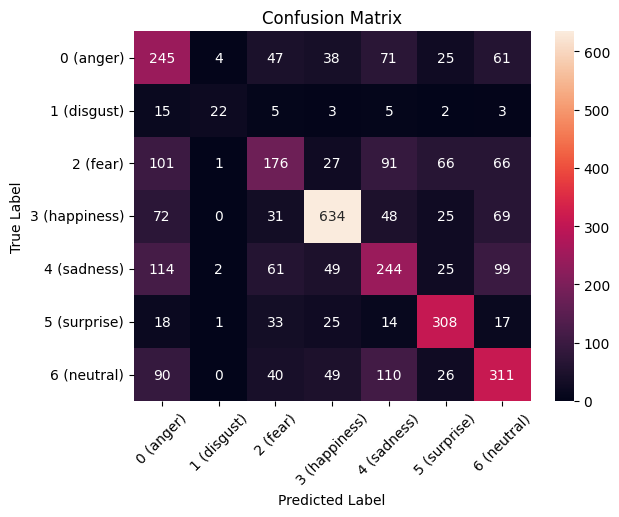

In [25]:
# Set up the matplotlib figure
# plt.figure(figsize=(10, 8))  # Adjust the size as needed

cm = confusion_matrix(y_test_numpy, pred_list)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cm, annot=True, fmt='d')

# Add titles and labels
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Optionally, adjust the x and y labels to match the categories if needed
# Assuming y_test_numpy and pred_list are encoded class labels:
# class_labels = ['Class 1', 'Class 2', 'Class 3']  # Adjust these as per your specific classes
class_labels = ['0 (anger)','1 (disgust)','2 (fear)','3 (happiness)','4 (sadness)','5 (surprise)','6 (neutral)']

plt.xticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation= 45)
plt.yticks(ticks=np.arange(len(class_labels)) + 0.5, labels=class_labels, rotation=0)

# Show the plot
plt.show()
